# Basic GAN

Nesse notebook, implementaremos uma GAN básica para gerar imagens similares às imagens do [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

Nesse notebook, os rótulos das 10 classes deste dataset **não serão usadas** durante o treinamento e inferência. Trataremos o dataset completo como uma amostra abstrata da população que produz esse tipo de imagem, tendo aproximadamente 10% dos dados para cada classe.

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as T

from tqdm.notebook import tqdm
from torchsummary import summary
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Definindo o discriminador

Tipicamente, em um discriminador convolucional, o bloco convolucional definido como `Conv - BatchNorm - LeakyReLU` é amplamente utilizado. Aqui, definimos uma classe para tornar esse bloco reutilizável ao longo da rede.

In [3]:
class DiscriminatorConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)
        

class Discriminator(nn.Module):
    def __init__(self, in_channels: int = 1):
        super().__init__()

        self.backbone = nn.Sequential(
            DiscriminatorConvBlock(in_channels, 64, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(64, 128, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(128, 256, kernel_size=4, stride=2, padding=1),
            DiscriminatorConvBlock(256, 512, kernel_size=3, stride=1, padding=1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

In [4]:
discriminator = Discriminator()
discriminator = discriminator.to(device)

summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
       BatchNorm2d-2           [-1, 64, 14, 14]             128
         LeakyReLU-3           [-1, 64, 14, 14]               0
DiscriminatorConvBlock-4           [-1, 64, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]         131,200
       BatchNorm2d-6            [-1, 128, 7, 7]             256
         LeakyReLU-7            [-1, 128, 7, 7]               0
DiscriminatorConvBlock-8            [-1, 128, 7, 7]               0
            Conv2d-9            [-1, 256, 3, 3]         524,544
      BatchNorm2d-10            [-1, 256, 3, 3]             512
        LeakyReLU-11            [-1, 256, 3, 3]               0
DiscriminatorConvBlock-12            [-1, 256, 3, 3]               0
           Conv2d-13            [-1, 512, 3, 3]       1,180,160
      BatchNorm2d-14      

In [5]:
# Initialize the Discriminator
discriminator = Discriminator().to(device)

## Definindo o gerador

O objetivo do gerador é de gerar uma imagem realista, similar àquelas do dataset utilizado, a partir de um ruído aleatório $z$.


O ruído aleatório $z \sim N(0,1)$ será um vetor unidimensional. Sendo assim, precisaremos utilizar uma série de convoluções transpostas para realizar um _upsampling_ para o tamanho da imagem original.

In [6]:
class Generator(nn.Module):
    def __init__(self, num_channels: int = 1, latent_size: int = 128):
        super().__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(latent_size, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, 7, 7))
        )

        self.upsampling_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(32, num_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.upsampling_layers(x)
        return self.final_layer(x)

In [7]:
generator = Generator()
generator = generator.to(device)

summary(generator, (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         809,088
       BatchNorm1d-2                 [-1, 6272]          12,544
         LeakyReLU-3                 [-1, 6272]               0
         Unflatten-4            [-1, 128, 7, 7]               0
   ConvTranspose2d-5           [-1, 64, 14, 14]         131,136
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8           [-1, 32, 28, 28]          32,800
       BatchNorm2d-9           [-1, 32, 28, 28]              64
        LeakyReLU-10           [-1, 32, 28, 28]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]             289
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 986,049
Trainable params: 986,049
Non-trainable params: 0
-------------------------------

## Treinamento da rede

In [8]:
def visualize_generated_images(generator, latent_dim, device, n_rows=2, n_cols=5):
    """
    Visualizes randomly generated images in a table format using the current parameters of the generator
    n_rows and n_cols are the numbers of rows and columns in the table of plots
    """
    generator.eval()  # Set generator to evaluation mode
    n_rows = n_rows
    n_cols = n_cols

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows):
        # Generate noise
        noise = torch.randn(n_cols, latent_dim).to(device)

        # Generate images
        with torch.no_grad():
            gen_imgs = generator(noise).cpu()

        # Plot images
        for j in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
            plt.imshow(gen_imgs[j].squeeze(), cmap="gray")
            plt.axis("off")
            if j == 0:
                plt.title(f"FashionMNIST")

    plt.tight_layout()
    plt.show()

In [9]:
in_channels = 1
latent_size = 100

num_workers = 2
batch_size = 64
num_epochs = 50
learning_rate = 2e-4

plot_frequency = 10  # plot every N epochs

transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize([0.5], [0.5])  # range [-1, 1] costuma funcionar melhor
])

fmnist_datapath = '/pgeoprj2/ciag2024/dados/'
dataset = datasets.FashionMNIST(fmnist_datapath, train=True, transform=transforms, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

discriminator = Discriminator(in_channels).to(device)
generator = Generator(in_channels, latent_size).to(device)

criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

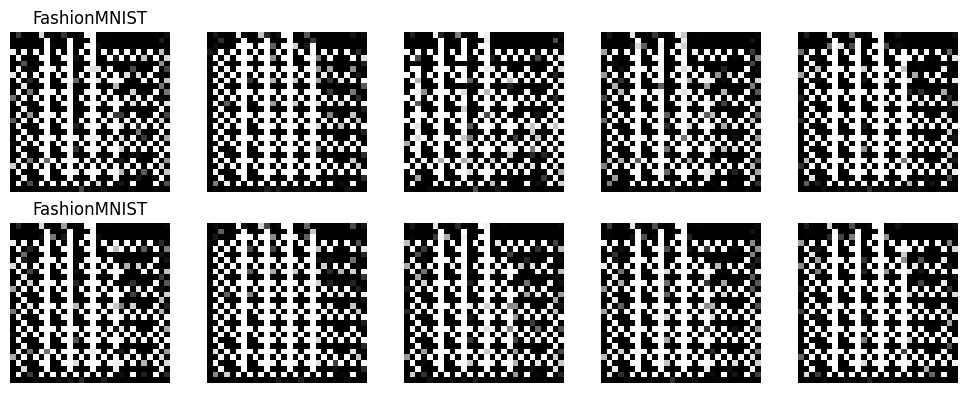

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

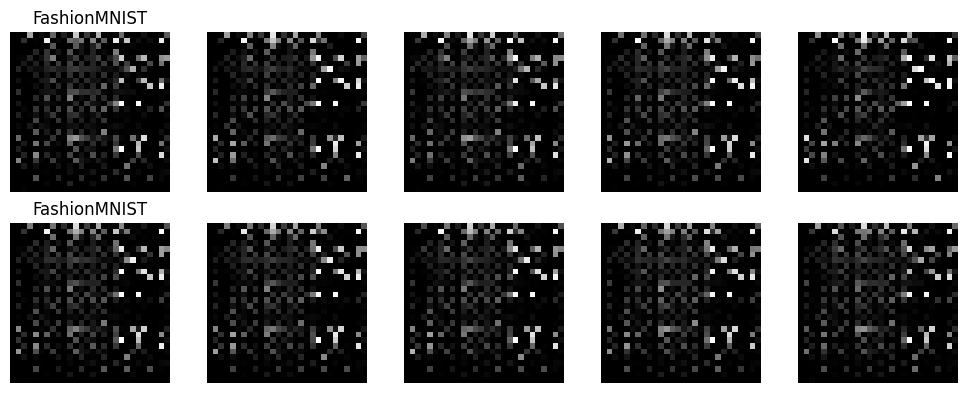

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

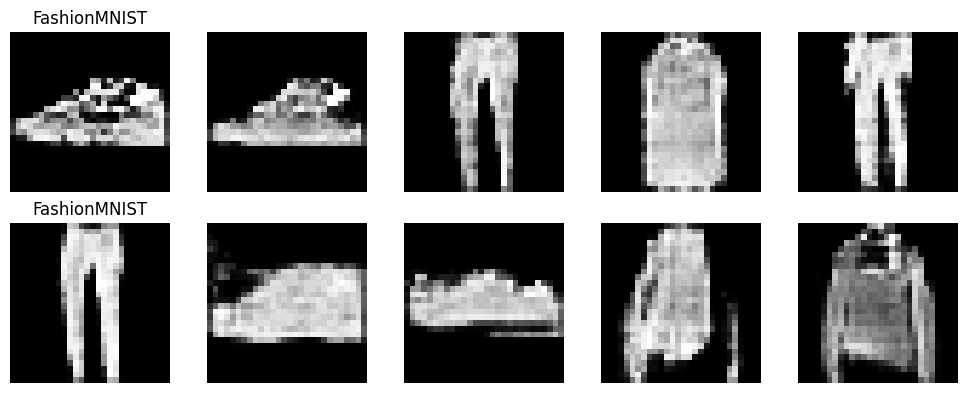

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

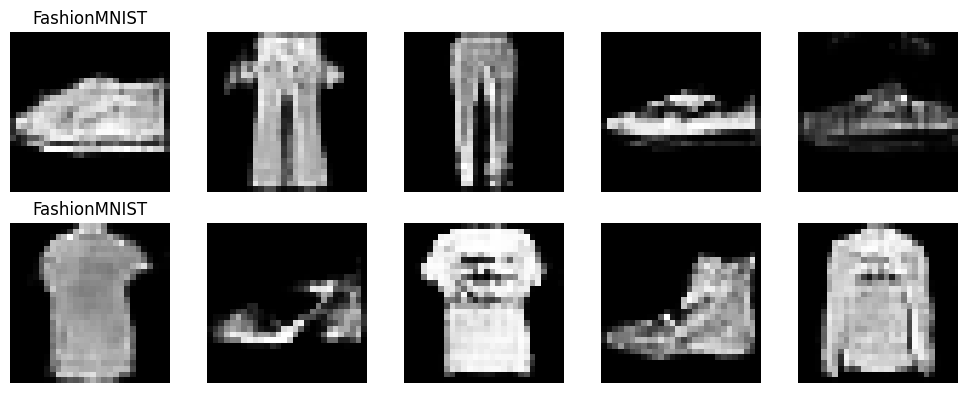

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

  0%|          | 0/938 [00:00<?, ?batch/s]

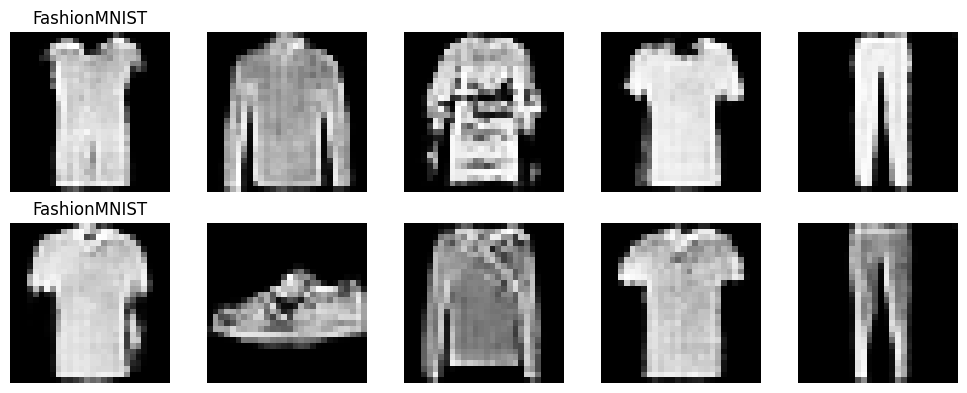

In [10]:
for epoch in range(num_epochs):
    d_train_loss = 0.0
    g_train_loss = 0.0

    for i, (real_imgs, _) in (
            pbar := tqdm(enumerate(dataloader), total=len(dataloader), unit='batch')
        ):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Definindo as labels reais (1) e fake (0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Treinamento do gerador
        g_optimizer.zero_grad()

        z = torch.randn(batch_size, latent_size).to(device)
        fake_imgs = generator(z)

        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Treinamento do discriminador
        d_optimizer.zero_grad()

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        # Store losses
        d_train_loss += d_loss.item()
        g_train_loss += g_loss.item()

        # Print progress
        pbar.set_description(
            f'Epoch {epoch+1}/{num_epochs} G_Loss: {g_train_loss/((i+1)):.4f} D_Loss: {d_train_loss/(i+1):.4f}'
        )

    # Visualize generated images every 10 epochs
    if (epoch+1) % plot_frequency == 0:
        visualize_generated_images(generator, latent_size, device, n_rows=2, n_cols=5)

## Notas do código de treinamento
### The generator loss function is not the min-max

We need to add some comments to this code. Rather than inserting them in the above cell, we put them separately here.

First, the calculation of the generator loss is made by this code line:
```
 g_loss = criterion(discriminator(fake_imgs), real_labels)
```
In a standard min-max GAN formulation, the Discriminator's objective is:
$$
\max_D \mathbb{E}_{\mathbf{x} \sim p_{\text{real}}} \left[ \log D(\mathbf{x}) \right] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} \left[ \log(1 - D(G(\mathbf{z}))) \right]
$$
while the Generator's objective is:
$$
\min_G \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}} \left[ \log(1 - D(G(\mathbf{z}))) \right]
$$
For G, we use only the second term present in the D loss fucntion because the first term does not involve the generator parameters. In the standard min-max  approach, the G loss function wants to minimize the probability that the Discriminator correctly classifies its generated images as fake (low probability from `D(G(z))`).

However, the original paper by Goodfellow and colleagues noticed that this formulation is quite bad for updating the G parameters. The gradient with respect to G parameters is practically zero in the beginning, when `D(G(z))` is confident (i.e., close to 0). It is said that the GAN suffers from **vanishing gradients** in this case and convergence will take a very long time. Because of that, they propose a change in the G loss function that breaks the beautiful min-max GAN formulation.

Instead of minimizing:
$$
\mathbb{E}_{\mathbf{z}} \left[  \log(1 - D(G(\mathbf{z}))) \right] \: ,
$$
a common trick is to minimize:
$$
\min_G \mathbb{E}_{\mathbf{z}} \left[ -\log D(G(\mathbf{z})) \right]
$$
This is equivalent to pass the fake images `G(z)` through the forward method of the discriminator and, because of the negative sign, try to maximize their average log-probabilities `log D(G(z))`.

This is mathematically equivalent to minimizing **Binary Cross-Entropy (BCE)** loss where **we use only  `G(z)`  images and set all the target labels to `1` (real images)** instead of `0` (fake images). This trick **ensures better gradient flow and training stability and speed**.

### How this relates to `g_loss` in the code

The implementation uses:
```python
g_loss = criterion(discriminator(fake_imgs), real_labels)
```
in which
- `discriminator(fake_imgs)` → Gives the probability **that the fake image is real**.
- `real_labels = torch.ones(batch_size, 1).to(device)` → Fake images are **labeled as real (`1`)** (ou $y_i = 1$ para todo $i$).
- `criterion = nn.BCELoss()` → Computes:

  $$
  \text{BCE Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(D(G(\mathbf{z}_i))) + (1 - y_i) \log(1 - D(G(\mathbf{z}_i))) \right] =
  - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(D(G(\mathbf{z}_i))) \right]
  $$
because all the targets $y_i$ are equal to 1.

### Using the original min-max loss fucntion

In case you want to use the **original** loss function:
$$
\mathbb{E}_{\mathbf{z}} \left[ \log(1 - D(G(\mathbf{z}))) \right]
$$
you should set the labels to **0** (fake), like this:
```python
g_loss = criterion(discriminator(fake_imgs), fake_labels)
```
where:
```python
fake = torch.zeros(batch_size, 1).to(device)
```
However, this **often leads to vanishing gradients**, making training unstable and convergence very lengthy.


### Why use `.detach()`

In the discriminator training, we used
 ```
 fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
 ```
why do we need to use `.detach()` here?

In an earlier step in the training loop, you generate `gen_imgs`:
   ```python
   gen_imgs = generator(z, gen_labels)
   ```
   - `gen_imgs` is generated by the **forward pass** of the Generator.
   - This step creates a **computation graph** that tracks every operation (used for backpropagation).

When `gen_imgs` is passed to the **Discriminator**, another computation graph would be built:
   ```python
   discriminator(gen_imgs, gen_labels)
   ```
   - Without `.detach()`, this **new computation graph would still be connected to the Generator's graph**, allowing gradients to flow back into the Generator's parameters during this step.

If gradients are not stopped, this would result in:
   - **Updating the Generator's parameters during Discriminator training**, which is not correct.
   - When you calculate `fake_loss.backward()`, it would also compute gradients for the Generator, which would make the training unstable.

Why no `detach()` in ´g_loss`?

When training the generator we used
```
g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
```
Here, we want gradients to flow back into the Generator so it can learn.


# Visualizando os resultados

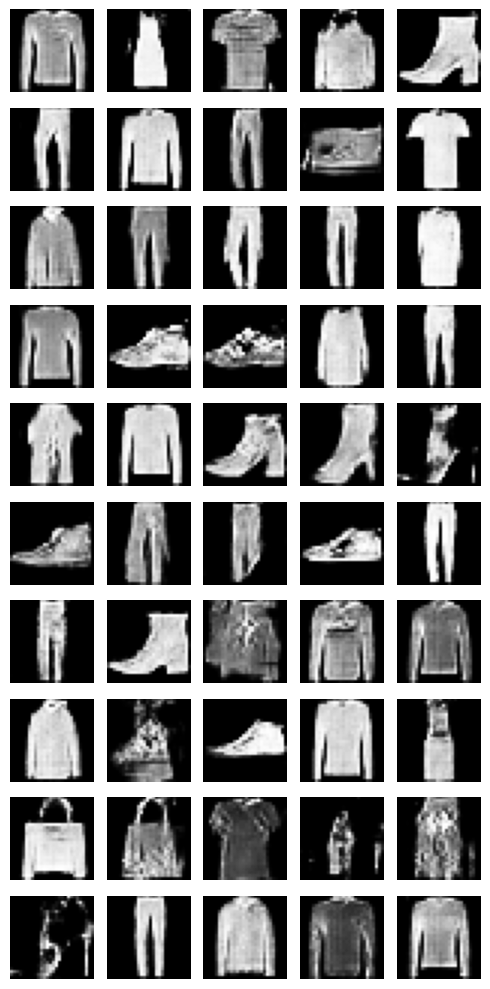

In [13]:
def generate_fixed_class_images(generator, latent_size, device, n_rows=10, n_cols=5):
    generator.eval()  # Set to evaluation mode
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))  # Create grid

    with torch.no_grad():
        for class_idx in range(n_rows):  # Each row corresponds to a fixed class
            z = torch.randn(n_cols, latent_size).to(device)  # Generate different noise vectors
            gen_imgs = generator(z).cpu()  # Generate images

            for col in range(n_cols):
                axes[class_idx, col].imshow(gen_imgs[col].squeeze(), cmap="gray")
                axes[class_idx, col].axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

# Generate images with fixed class rows
generate_fixed_class_images(generator, latent_size, device, n_rows=10, n_cols=5)